# Import Libraries

In [1]:
!pip install tensorflow==2.8.0 tensorflow-io==0.25.0 matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 702.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 399.8 kB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.37.0

#Load Libraries

In [2]:
 import tensorflow as tf
 import os
 import matplotlib.pyplot as plt
 import tensorflow_io as tfio

# Connecting to my Google Drive

In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


# Creating Data Loading Function

### Define Path to the Files

In [4]:
capuchin_file = os.path.join('/content','drive','My Drive','YOUTUBE','Deep_Learning','Audio_Classifier','data','Parsed_Capuchinbird_Clips','XC3776-3.wav')
not_capuchin_file = os.path.join('/content','drive','My Drive','YOUTUBE','Deep_Learning','Audio_Classifier','data','Parsed_Not_Capuchinbird_Clips','afternoon-birds-song-in-forest-0.wav')

### Create Dataloading Function

In [5]:
'''from tensor flow documentation'''
def load_wav_16k_mono(filename): # converting audio into 16 Hz and get a single channel
  file_contents = tf.io.read_file(filename) #byte endoed string

  wav,sample_rate = tf.audio.decode_wav(file_contents,desired_channels = 1)

  wav = tf.squeeze(wav, axis=-1)
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)

  wav =tfio.audio.resample(wav, rate_in=sample_rate,rate_out=16000)
  return wav

In [6]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [7]:
file_contents = tf.io.read_file(capuchin_file)

In [8]:
wav,sample_rate = tf.audio.decode_wav(file_contents,desired_channels = 1)
sample_rate

<tf.Tensor: shape=(), dtype=int32, numpy=44100>

### Plot Waves

In [9]:
wav = load_wav_16k_mono(capuchin_file)
nwav = load_wav_16k_mono(not_capuchin_file)

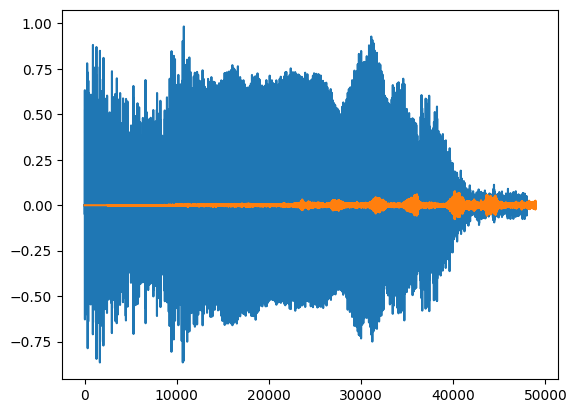

In [10]:
plt.plot(wav)
plt.plot(nwav)
plt.show()

# Creating Tensorflow Dataset

### Define Paths to Postiive and Negative Data

In [11]:
POS = os.path.join('/content','drive','My Drive','YOUTUBE','Deep_Learning','Audio_Classifier','data','Parsed_Capuchinbird_Clips')
NEG = os.path.join('/content','drive','My Drive','YOUTUBE','Deep_Learning','Audio_Classifier','data','Parsed_Not_Capuchinbird_Clips')

### Create Tensorflow Datasets

In [12]:
pos_tf = tf.data.Dataset.list_files(POS+'/*.wav')
neg_tf = tf.data.Dataset.list_files(NEG+'/*.wav')

In [13]:
pos_tf.as_numpy_iterator().next()

b'/content/drive/My Drive/YOUTUBE/Deep_Learning/Audio_Classifier/data/Parsed_Capuchinbird_Clips/XC227468-1.wav'

### Add label and Combine Postive and Negative Samples

In [14]:
positives = tf.data.Dataset.zip((pos_tf, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos_tf)))))
negatives = tf.data.Dataset.zip((neg_tf, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg_tf)))))
data = positives.concatenate(negatives)

In [15]:
data.shuffle(10000).as_numpy_iterator().next()

(b'/content/drive/My Drive/YOUTUBE/Deep_Learning/Audio_Classifier/data/Parsed_Not_Capuchinbird_Clips/birds-singing-in-forest-sounds-6.wav',
 0.0)

# Determine Average Length of a Capuchin Call

### Calculate Wave Cycle Length

In [16]:
lengths = []
for file in os.listdir(os.path.join('/content','drive','My Drive','YOUTUBE','Deep_Learning','Audio_Classifier','data','Parsed_Capuchinbird_Clips')):
  tensor_wave = load_wav_16k_mono(os.path.join('/content','drive','My Drive','YOUTUBE','Deep_Learning','Audio_Classifier','data','Parsed_Capuchinbird_Clips',file))
  lengths.append(len(tensor_wave))

In [17]:
os.listdir(os.path.join(os.path.join('/content','drive','My Drive','YOUTUBE','Deep_Learning','Audio_Classifier','data','Parsed_Capuchinbird_Clips')))

['XC114131-0.wav',
 'XC114131-1.wav',
 'XC114131-2.wav',
 'XC114131-3.wav',
 'XC114132-0.wav',
 'XC114131-4.wav',
 'XC114132-1.wav',
 'XC114132-2.wav',
 'XC114132-3.wav',
 'XC114132-4.wav',
 'XC114132-6.wav',
 'XC16803-0.wav',
 'XC16803-1.wav',
 'XC114132-5.wav',
 'XC119294-0.wav',
 'XC16803-2.wav',
 'XC178167-0.wav',
 'XC168899-0.wav',
 'XC178167-1.wav',
 'XC16804-0.wav',
 'XC16804-1.wav',
 'XC178167-2.wav',
 'XC178168-3.wav',
 'XC178168-1.wav',
 'XC178168-0.wav',
 'XC178167-3.wav',
 'XC178168-2.wav',
 'XC216010-1.wav',
 'XC201990-3.wav',
 'XC178168-4.wav',
 'XC201990-2.wav',
 'XC201990-4.wav',
 'XC178168-6.wav',
 'XC178168-7.wav',
 'XC201990-1.wav',
 'XC216010-2.wav',
 'XC216010-0.wav',
 'XC201990-5.wav',
 'XC201990-0.wav',
 'XC178168-5.wav',
 'XC216012-11.wav',
 'XC216012-10.wav',
 'XC216012-0.wav',
 'XC216010-4.wav',
 'XC216010-5.wav',
 'XC216010-7.wav',
 'XC216010-6.wav',
 'XC216010-3.wav',
 'XC216012-12.wav',
 'XC216012-1.wav',
 'XC216012-14.wav',
 'XC216012-18.wav',
 'XC216012-1

In [18]:
lengths

[40000,
 48000,
 56000,
 48000,
 64000,
 56000,
 64000,
 64000,
 56000,
 56000,
 56000,
 56000,
 40000,
 48000,
 64000,
 64000,
 56000,
 64000,
 56000,
 64000,
 64000,
 56000,
 56000,
 48000,
 48000,
 56000,
 56000,
 56000,
 32000,
 64000,
 64000,
 40000,
 48000,
 56000,
 56000,
 56000,
 40000,
 48000,
 64000,
 64000,
 48000,
 64000,
 64000,
 56000,
 48000,
 64000,
 48000,
 56000,
 48000,
 48000,
 48000,
 48000,
 48000,
 40000,
 56000,
 40000,
 56000,
 48000,
 40000,
 56000,
 56000,
 48000,
 48000,
 56000,
 48000,
 56000,
 64000,
 40000,
 56000,
 64000,
 64000,
 56000,
 72000,
 40000,
 56000,
 64000,
 56000,
 64000,
 56000,
 48000,
 48000,
 56000,
 56000,
 48000,
 56000,
 48000,
 56000,
 40000,
 56000,
 56000,
 56000,
 56000,
 48000,
 40000,
 64000,
 56000,
 56000,
 64000,
 56000,
 56000,
 64000,
 48000,
 64000,
 48000,
 64000,
 64000,
 48000,
 56000,
 56000,
 48000,
 48000,
 56000,
 64000,
 64000,
 48000,
 56000,
 48000,
 48000,
 48000,
 64000,
 48000,
 48000,
 48000,
 64000,
 40000,


### Caluclate Mean, Min and Max

In [19]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [20]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [21]:
tf.math.reduce_max (lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [22]:
print(f"Mean per cycle:{54156/16000}")
print(f"Min per cycle:{32000/16000}")
print(f"Max per cycle:{80000/16000}")

Mean per cycle:3.38475
Min per cycle:2.0
Max per cycle:5.0


# Build Preprocessing Function to Convert to Spectogram

### Build Preprocessing Function

In [23]:
def preprocess(file_path,label):
  wav = load_wav_16k_mono(file_path)
  wav = wav[:48000]
  zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
  wav = tf.concat([zero_padding,wav],0)
  spectrogram = tf.signal.stft(wav, frame_length = 320, frame_step = 32)
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, axis = 2)
  return spectrogram,label

### Test out the function and viz the spectorgram

In [24]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [25]:
spectrogram, label = preprocess(filepath, label)

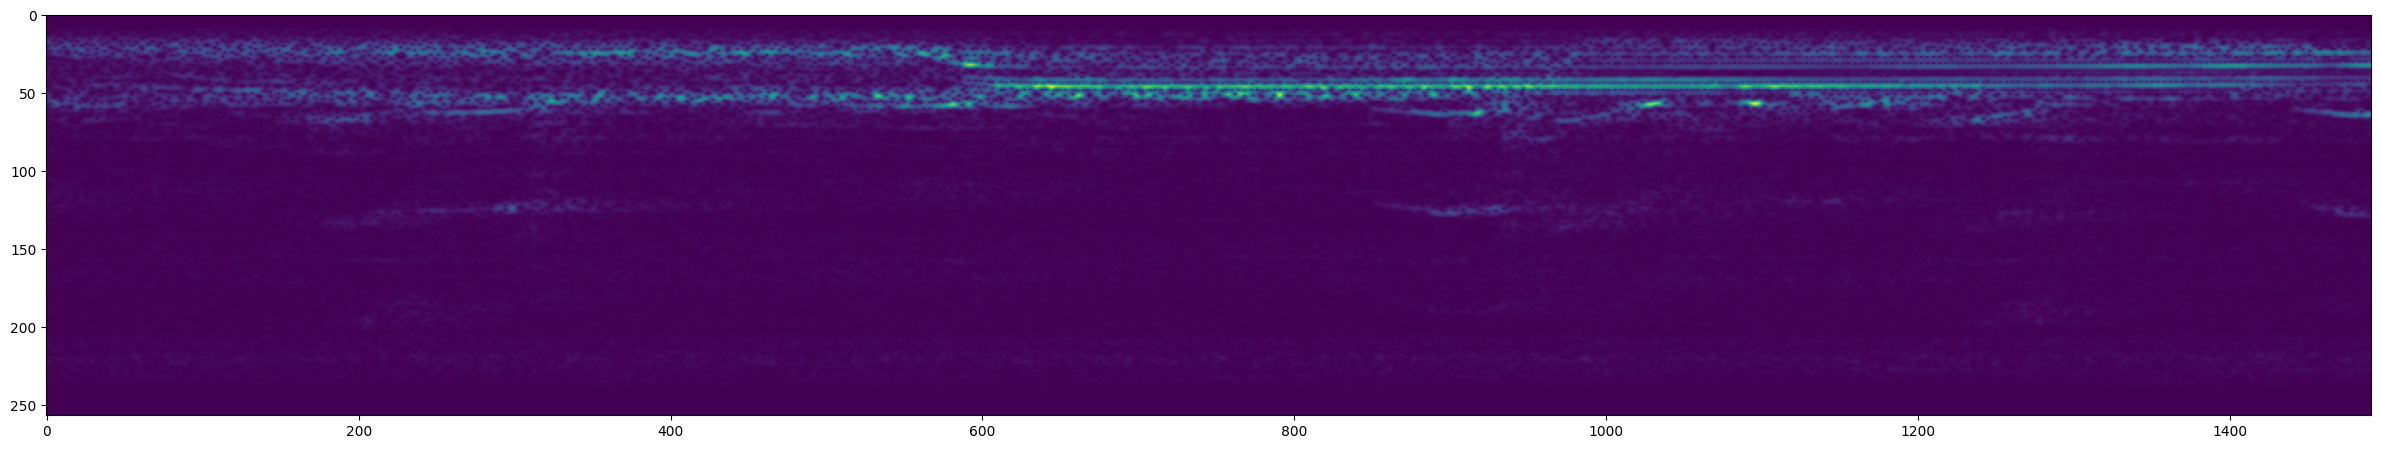

In [26]:
plt.figure(figsize = (30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [27]:
filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [28]:
spectrogram, label = preprocess(filepath, label)

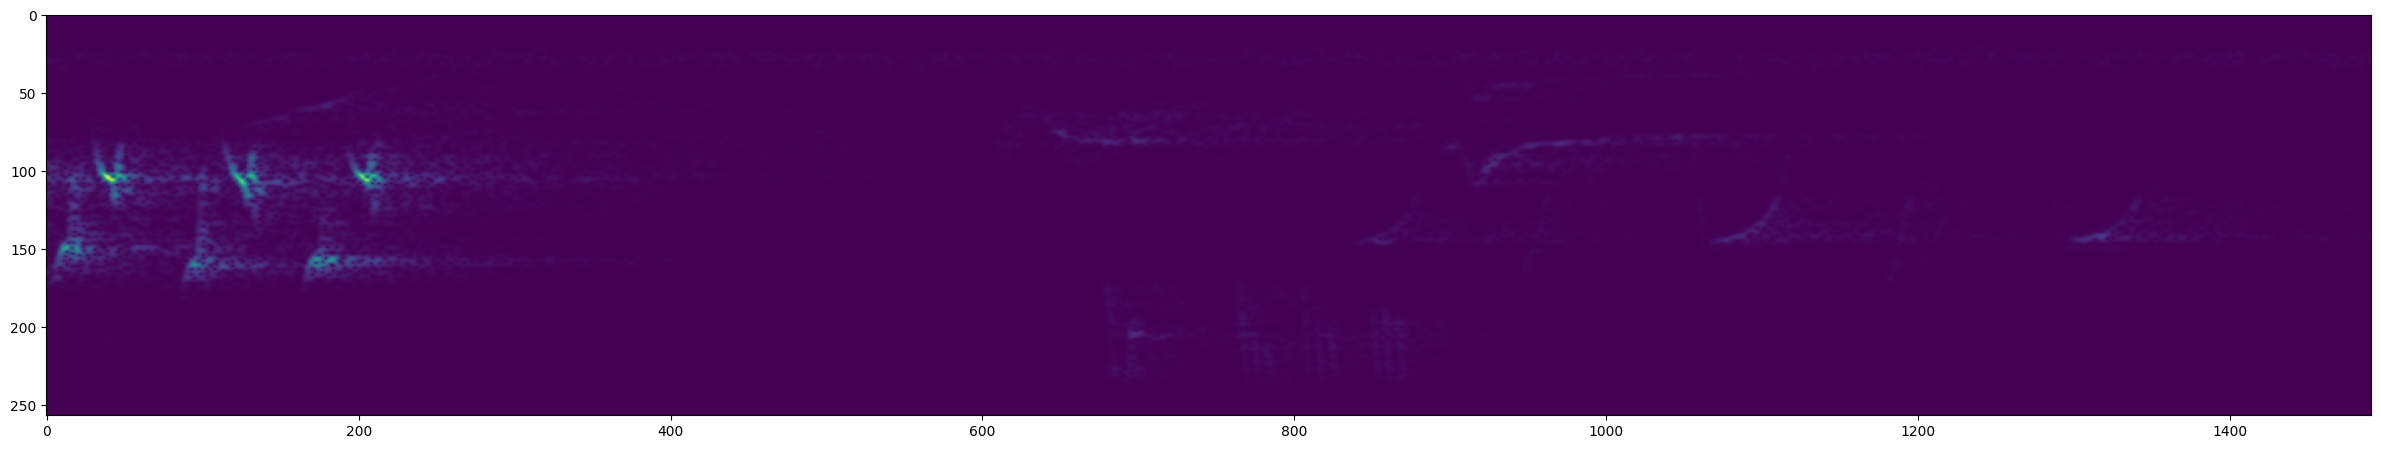

In [29]:
plt.figure(figsize = (30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# Creating training and testing partitions

### Create a Tensorflow Data Pipeline

In [30]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size = 1000)
data = data.batch(16)
data = data.prefetch(8)

### Split into training and testing partitions

In [31]:
train = data.take(36)
test = data.skip(36).take(15)

### Test One Batch

In [32]:
samples, labels = train.as_numpy_iterator().next()

In [33]:
labels

array([0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
      dtype=float32)

# Build Deep Learning Model

### Load Tensorflow Dependencies

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

### Build Sequential Model, COmpile and View Summary

In [35]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation = 'relu', input_shape = (1491,257,1)))
model.add(Conv2D(16, (3,3), activation = 'relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [37]:
model.compile('Adam', loss = 'BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 128)               770480256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770,482,865
Trainable params: 770,482,865
Non-trainable params: 0
_________________________________________________________________


### Fit Model, View Loss and KPI Plots

In [39]:
hist = model.fit(train, epochs=10, validation_data=test)

Epoch 1/10
36/36 [==============================] - 147s 4s/step - loss: 5.8153 - recall: 0.8982 - precision: 0.8475 - val_loss: 0.1041 - val_recall: 1.0000 - val_precision: 0.9178
Epoch 2/10
36/36 [==============================] - 142s 4s/step - loss: 0.1112 - recall: 0.9872 - precision: 0.9625 - val_loss: 0.0628 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 3/10
36/36 [==============================] - 141s 4s/step - loss: 0.0500 - recall: 1.0000 - precision: 0.9865 - val_loss: 0.0336 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/10
36/36 [==============================] - 142s 4s/step - loss: 0.0383 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0353 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 5/10
36/36 [==============================] - 136s 4s/step - loss: 0.0254 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0255 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 6/10
36/36 [==============================] - 140s 4s/step - loss: 0.0255 - recall: 0.993

In [48]:
hist.history['val_loss']

[0.10405101627111435,
 0.06284846365451813,
 0.03361111879348755,
 0.03531984984874725,
 0.02550402097404003,
 0.022527417168021202,
 0.01981998048722744,
 0.002728018444031477,
 0.001742984401062131,
 0.001405293820425868]

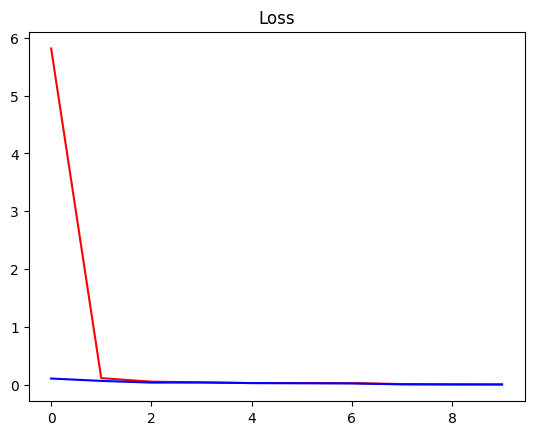

In [41]:
plt.title('Loss')
plt.plot(hist.history['loss'],'r')
plt.plot(hist.history['val_loss'],'b')
plt.show()

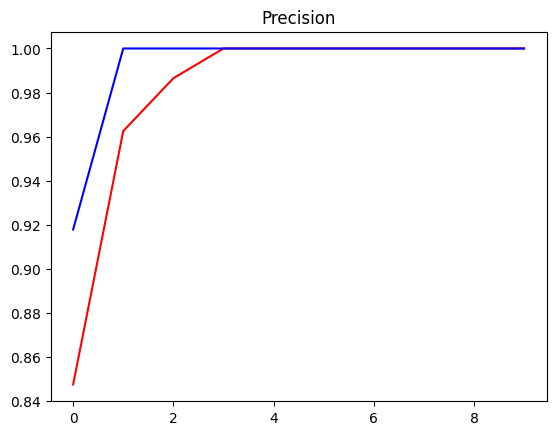

In [42]:
plt.title('Precision')
plt.plot(hist.history['precision'],'r')
plt.plot(hist.history['val_precision'],'b')
plt.show()

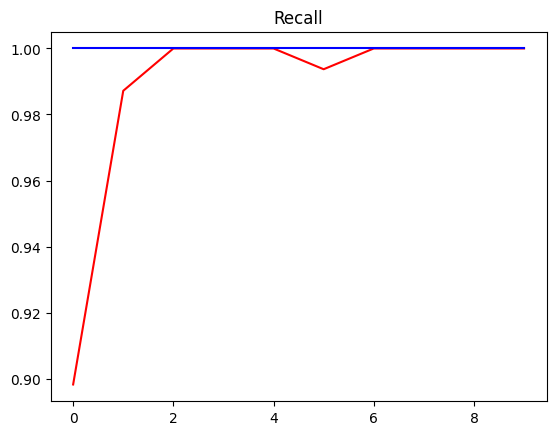

In [43]:
plt.title('Recall')
plt.plot(hist.history['recall'],'r')
plt.plot(hist.history['val_recall'],'b')
plt.show()

# Make a Prediction on a Single CLip

### Get One Batch and Make a Prediction

In [89]:
 X_test, y_test = test.as_numpy_iterator().next()

In [90]:
y_test.shape

(16,)

In [91]:
yhat = model.predict(X_test)

### Convert Logits to Classes

In [92]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [93]:
yhat

[0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [94]:
y_test

array([0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
      dtype=float32)

In [95]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=4>

In [96]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=4.0>

# Build Forest Parsing Functions

### Load up MP3s

In [129]:
def load_mp3_16k_mono(filename):

  res = tfio.audio.AudioIOTensor(filename)

  tensor = res.to_tensor()
  tensor = tf.math.reduce_sum(tensor,axis = 1)/2

  sample_rate = res.rate
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)

  wav = tfio.audio.resample(tensor, rate_in = sample_rate, rate_out =16000)
  return wav


In [130]:
mp3 = os.path.join('/content','drive','My Drive','YOUTUBE','Deep_Learning','Audio_Classifier','data', 'Forest Recordings' ,'recording_00.mp3')

In [131]:
wav = load_mp3_16k_mono(mp3)

In [132]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav,wav,sequence_length= 48000, sequence_stride=48000, batch_size= 1)

In [133]:
sample, index = audio_slices.as_numpy_iterator().next()

### Build Function to Convert Clips into Windowed Spectograms

In [134]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

### Convert Longer Clips into Windows and Make Predictions

In [144]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [145]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

In [146]:
yhat

[0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

### Group Consecutive Detections

In [147]:
from itertools import groupby

In [148]:
yhat = [key for key, group in groupby(yhat)]

In [151]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=5>

# Make Predicitions

### Loop over all recordings and make predictions

In [152]:
results = {}

for file in os.listdir(os.path.join('/content','drive','My Drive','YOUTUBE','Deep_Learning','Audio_Classifier','data', 'Forest Recordings')):
  FILEPATH = os.path.join('/content','drive','My Drive','YOUTUBE','Deep_Learning','Audio_Classifier','data', 'Forest Recordings' ,file)

  wav = load_mp3_16k_mono(FILEPATH)
  audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav,wav, sequence_length=48000, sequence_stride = 48000, batch_size = 1)
  audio_slices = audio_slices.map(preprocess_mp3)
  audio_slices = audio_slices.batch(64)

  yhat = model.predict(audio_slices)
  results[file] = yhat


In [153]:
results

{'recording_00.mp3': array([[4.64528799e-04],
        [2.18151922e-06],
        [1.69886443e-05],
        [9.99969125e-01],
        [1.00000000e+00],
        [2.25257921e-07],
        [3.35325240e-07],
        [7.77342208e-08],
        [3.62265915e-08],
        [1.20081837e-04],
        [1.04140981e-05],
        [6.69092969e-06],
        [6.91657187e-05],
        [1.00000000e+00],
        [1.00000000e+00],
        [3.62124979e-06],
        [4.49388389e-20],
        [2.79166147e-06],
        [5.46723604e-04],
        [1.60366297e-04],
        [4.91440296e-04],
        [2.48795059e-05],
        [5.18918037e-04],
        [1.23672187e-02],
        [1.00000000e+00],
        [3.35005922e-07],
        [2.39037368e-09],
        [4.84590928e-05],
        [7.72052736e-05],
        [3.74796546e-05],
        [4.90614366e-06],
        [2.09268928e-03],
        [1.41617634e-13],
        [6.59910526e-08],
        [3.27855349e-04],
        [1.52806535e-06],
        [1.00000000e+00],
        [2.3527950

### Convert Predictions into Classes

In [154]:
class_preds = {}

for file, logits in results.items():
  class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_00.mp3': [0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

### Group Consecutive Detections

In [158]:
postprocessed = {}
for file,scores in class_preds.items():
  postprocessed[file]= tf.math.reduce_sum([[key for key, group in groupby(scores)]]).numpy()

In [175]:
max(postprocessed.values())

25

# Export csv

In [164]:
import csv

In [167]:
with open('/content/drive/My Drive/YOUTUBE/Deep_Learning/Audio_Classifier/capuchinbird_call_results.csv','w',newline='') as f:
  writer = csv.writer(f,delimiter=',')
  writer.writerow(['recording','capuchin_calls'])
  for key, value in postprocessed.items():
    writer.writerow([key,value])
